<a href="https://colab.research.google.com/github/N-django/data-analysis-vehicle-Insuranceclaims/blob/main/Poisson_GLM_for_claim_Frequency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd


df = pd.read_excel('/content/drive/MyDrive/Motor Private Dataset.xlsx')


df.head()

,CMB_CLAIM_NO,POLICY_NO,EF,ET,LOSS_DATE,REPORT DATE,Vehicle_ID,YOM,AGE_CATEGORY,CAR_AGE,COLORS,CUBIC_CAPACITY,CARRY_CAPACITY,BODY TYPE,REG_Name,VEHICLE MAKE,VEHICLE MODELS,GROSS_PAID
0,C/10/700/043075,10/700/0030439,06/09/2023,06/08/2024,2024-05-13,2024-05-14,KCY 676R,2014.0,8+ Years,10.0,BLACK,2493.0,5.0,STATION WAGON,TOYOTA HARRIER HYBDRID,TOYOTA,TOYOTA HARRIER,0.0
1,C/12/700/041177,12/700/0071745,03/01/2023,02/29/2024,2024-01-26,2024-02-15,KCM 432W,2011.0,8+ Years,13.0,WHITE,2400.0,5.0,STATION WAGON,TOYOTA RAV4,TOYOTA,TOYOTA RAV4,0.0
2,C/40/700/037888,AE700/0065804/000/00,03/03/2023,01/24/2024,2023-08-30,2023-09-01,KDL 192F,2017.0,4-7 Years,7.0,SILVER,1496.0,5.0,STATION WAGON,SUBARU FORESTER,SUBARU,SUBARU FORESTER,0.0
3,C/10/700/036490,10/700/0101357,01/01/2023,12/31/2023,2023-04-14,2023-06-19,KBZ 107K,2007.0,8+ Years,17.0,SILVER,1496.0,5.0,SEDAN,SALOON AUTO,UNKNOWN,SALOON AUTO,0.0
4,C/15/700/033788,AI700/0060894/000/00,09/21/2022,07/20/2023,2023-01-23,2023-01-30,KCH 319U,2009.0,8+ Years,15.0,BLACK,2488.0,5.0,STATION WAGON,NISSAN XTRAIL,NISSAN,NISSAN X-TRAIL,0.0


In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import re
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm


In [ ]:
median_yom = df['YOM'].median()
df['YOM']= df['YOM'].fillna(median_yom)

mean_car_age = df['CAR_AGE'].mean()
mean_cubic_capacity = df['CUBIC_CAPACITY'].mean()
mean_carry_capacity = df['CARRY_CAPACITY'].mean()

df['CAR_AGE'] = df['CAR_AGE'].fillna(mean_car_age)
df['CUBIC_CAPACITY'] = df['CUBIC_CAPACITY'].fillna(mean_cubic_capacity)
df['CARRY_CAPACITY'] = df['CARRY_CAPACITY'].fillna(mean_carry_capacity)
df['REG_Name']=df['REG_Name'].fillna('UNKNOWN')
df['GROSS_PAID']=df['GROSS_PAID'].fillna(0)

Blank_columns = df.isna().sum()

df['Claim_Frequency'] = df.groupby('Vehicle_ID')['CMB_CLAIM_NO'].transform('count')
print(f"Total number of missing values: {Blank_columns}")

Total number of missing values: CMB_CLAIM_NO      0
POLICY_NO         0
EF                0
ET                0
LOSS_DATE         0
REPORT DATE       0
Vehicle_ID        0
YOM               0
AGE_CATEGORY      0
CAR_AGE           0
 COLORS           0
CUBIC_CAPACITY    0
CARRY_CAPACITY    0
BODY TYPE         0
REG_Name          0
VEHICLE MAKE      0
VEHICLE MODELS    0
GROSS_PAID        0
dtype: int64


In [ ]:
print("Unique VEHICLE MAKE values:")
print(df['VEHICLE MAKE'].unique())

print("Unique VEHICLE MODEL values:")
print(df['VEHICLE MODELS'].unique())

print("Unique BODY TYPE values:")
print(df['BODY TYPE'].unique())

print("Unique COLORS values:")
print(df[' COLORS'].unique())
# df_encoded = pd.get_dummies(df, columns=['VEHICLE MAKE', 'BODY TYPE', ' COLORS'], drop_first=True)



Unique VEHICLE MAKE values:
['TOYOTA' 'SUBARU' 'UNKNOWN' 'NISSAN' 'GEO' 'ISUZU' 'MERCEDES BENZ'
 'MITSUBISHI' 'SUZUKI' 'VOLKSWAGEN' 'HONDA' 'MAZDA' 'LAND ROVER' 'BMW'
 'LEXUS' 'FORD' 'JEEP' 'VOLVO' 'PROTON' 'DAIHATSU' 'HYUNDAI' 'RENAULT'
 'PORSCHE' 'OPEL' 'CHEVROLET' 'MAHINDRA' 'KIA' 'CHERY' 'FOTON' 'MOBIUS'
 'JAGUAR' 'GEELY' 'DODGE' 'VAUXHALL' 'TATA' 'CHRYSLER' 'JMC' 'CITROEN'
 'HUMMER' 'MINI' 'SKODA']
Unique VEHICLE MODEL values:
['TOYOTA HARRIER' 'TOYOTA RAV4' 'SUBARU FORESTER' 'SALOON AUTO'
 'NISSAN X-TRAIL' 'TOYOTA AXIO' 'TOYOTA ' 'TOYOTA LANDCRUISER'
 'TOYOTA NOAH' 'TOYOTA DBA' 'TOYOTA FIELDER' 'PEUGEOT 508' 'TOYOTA PROBOX'
 'ISUZU DMAX' 'TOYOTA PREMIO' 'TOYOTA BB' 'TOYOTA ACQUA' 'UNKNOWN'
 'TOYOTA COROLLA' 'TOYOTA ISIS' 'NISSAN NOTE' 'MERCEDES BENZ'
 'TOYOTA SUCCEED' 'CBABL5' 'NISSAN TILDA' 'MITSUBISHI' 'SUZUKI ESCUDO'
 'TOYOTA CORONA' 'TOYOTA SIENTA' 'SUBARU' 'VOLKSWAGEN GOLF' 'NISSAN JUKE'
 'TOYOTA WISH' 'TOYOTA VITZ' 'NISSAN DUALIS' 'TOYOTA VANGUARD' 'NISSAN'
 'HONDA FIT SHUT

In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.3 MB/s eta 0:00:00


In [ ]:
df.columns



Index(['CMB_CLAIM_NO', 'POLICY_NO', 'EF', 'ET', 'LOSS_DATE', 'REPORT DATE',
       'Vehicle_ID', 'YOM', 'AGE_CATEGORY', 'CAR_AGE', ' COLORS',
       'CUBIC_CAPACITY', 'CARRY_CAPACITY', 'BODY TYPE', 'REG_Name',
       'VEHICLE MAKE', 'VEHICLE MODELS', 'GROSS_PAID', 'Claim_Frequency'],
      dtype='object')

In [ ]:
!pip install category_encoders


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.6 MB/s eta 0:00:00



## Fitting Standard poisson with target encoding

In [ ]:
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split

categorical_cols = [' COLORS', 'BODY TYPE', 'VEHICLE MAKE', 'VEHICLE MODELS']
numerical_cols = ['CAR_AGE', 'CUBIC_CAPACITY', 'CARRY_CAPACITY']
target = 'Claim_Frequency'

# Target encode categorical variables
encoder = TargetEncoder(cols=categorical_cols)
df_encoded = encoder.fit_transform(df[categorical_cols], df[target])

# Combine numerical and encoded categorical features
X = pd.concat([df[numerical_cols], df_encoded], axis=1)

# Add a constant (intercept term) for the GLM
X = sm.add_constant(X)

# Target variable
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a GLM model with Poisson distribution
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

# Print model summary
print(poisson_results.summary())

# Predict on test set
y_pred = poisson_results.predict(X_test)

# Evaluate predictions
print("Predicted values:", y_pred[:5])

                 Generalized Linear Model Regression Results                  
Dep. Variable:        Claim_Frequency   No. Observations:                33949
Model:                            GLM   Df Residuals:                    33941
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -48824.
Date:                Tue, 22 Oct 2024   Deviance:                       16902.
Time:                        13:13:13   Pearson chi2:                 1.98e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01730
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.7429      0.301     -5.

In [ ]:
import statsmodels.api as sm

# Assuming your model is fitted and named 'model'
deviance_value = poisson_results.deviance
aic_value = poisson_results.aic

print("Deviance:", deviance_value)
print("AIC:", aic_value)

Deviance: 16902.146530639056
AIC: 97664.49239866258


# ***CROSS VALIDATION OF THE GLM WITH ONE HOT ENCODING***

In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# Specify categorical and numerical columns
categorical_cols = [' COLORS', 'BODY TYPE', 'VEHICLE MAKE', 'VEHICLE MODELS']
numerical_cols = ['CAR_AGE', 'CUBIC_CAPACITY', 'CARRY_CAPACITY']
target = 'Claim_Frequency'

# One-hot encode the categorical variables
df_encoded = pd.get_dummies(df[categorical_cols], drop_first=True)

# Combine numerical and encoded categorical features
X = pd.concat([df[numerical_cols], df_encoded], axis=1)

# Add a constant (intercept term) for the GLM
X = sm.add_constant(X)
X = X.astype(int)

# Target variable
y = df[target]

# Custom function to fit GLM model with Poisson distribution
def poisson_glm(X_train, y_train, X_test):
    model = sm.GLM(y_train, X_train, family=sm.families.Poisson())
    results = model.fit()
    return results.predict(X_test)

# Custom scoring function (MSE)
def glm_cross_val_score(X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    mse_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit model and predict
        y_pred = poisson_glm(X_train, y_train, X_test)

        # Calculate MSE and store the score
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)

    return np.mean(mse_scores), np.std(mse_scores)

# Perform 5-fold cross-validation
mean_mse, std_mse = glm_cross_val_score(X, y, cv=5)

print(f"Cross-Validation MSE: {mean_mse:.4f} (± {std_mse:.4f})")

Cross-Validation MSE: 1.0562 (± 0.0216)


In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Specify categorical and numerical columns
categorical_cols = [' COLORS', 'BODY TYPE', 'VEHICLE MAKE', 'VEHICLE MODELS']
numerical_cols = ['CAR_AGE', 'CUBIC_CAPACITY', 'CARRY_CAPACITY']
target = 'Claim_Frequency'

# One-hot encode the categorical variables
df_encoded = pd.get_dummies(df[categorical_cols], drop_first=True)

# Combine numerical and encoded categorical features
X = pd.concat([df[numerical_cols], df_encoded], axis=1)

# Convert boolean columns to integers
X = X.astype(int)

# Debug step: Check data types again to ensure all columns are numeric
print(X.dtypes)

# Add a constant (intercept term) for the GLM
X = sm.add_constant(X)

# Target variable
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a GLM model with Poisson distribution
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

# Print model summary
print(poisson_results.summary())

# Predict on test set
y_pred = poisson_results.predict(X_test)

# Evaluate predictions
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Predicted values:", y_pred[:5])



CAR_AGE                      int64
CUBIC_CAPACITY               int64
CARRY_CAPACITY               int64
 COLORS_BLACK                int64
 COLORS_BLUE                 int64
                             ...  
VEHICLE MODELS_VOLVO V60     int64
VEHICLE MODELS_VOLVO V70     int64
VEHICLE MODELS_VOLVO XC60    int64
VEHICLE MODELS_VOLVO XC90    int64
VEHICLE MODELS_WHEELER       int64
Length: 642, dtype: object
                 Generalized Linear Model Regression Results                  
Dep. Variable:        Claim_Frequency   No. Observations:                33949
Model:                            GLM   Df Residuals:                    33364
Model Family:                 Poisson   Df Model:                          584
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -48708.
Date:                Tue, 22 Oct 2024   Deviance:                       16670.
Time:                        13:10:

# Above Model Evaluation

In [ ]:
import statsmodels.api as sm

# Assuming your model is fitted and named 'model'
deviance_value = poisson_results.deviance
aic_value = poisson_results.aic

print("Deviance:", deviance_value)
print("AIC:", aic_value)

Deviance: 16670.49144608769
AIC: 98586.8373141112


# With Interaction Terms

In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Specify categorical and numerical columns
categorical_cols = [' COLORS', 'BODY TYPE', 'VEHICLE MAKE', 'VEHICLE MODELS']
numerical_cols = ['CAR_AGE', 'CUBIC_CAPACITY', 'CARRY_CAPACITY']
target = 'Claim_Frequency'

# One-hot encode the categorical variables
df_encoded = pd.get_dummies(df[categorical_cols], drop_first=True)

# Combine numerical and encoded categorical features
X = pd.concat([df[numerical_cols], df_encoded], axis=1)

# Create interaction terms between CAR_AGE and CARRY_CAPACITY, CUBIC_CAPACITY and CARRY_CAPACITY, CARRY_CAPACITY and COLORS
X['CAR_AGE_CARRY_CAPACITY'] = X['CAR_AGE'] * X['CARRY_CAPACITY']
X['CUBIC_CAPACITY_CARRY_CAPACITY'] = X['CUBIC_CAPACITY'] * X['CARRY_CAPACITY']

# For CARRY_CAPACITY and COLORS, create interaction with all one-hot encoded colors
color_columns = [col for col in df_encoded.columns if ' COLORS' in col]
for col in color_columns:
    X[f'CARRY_CAPACITY_{col}'] = X['CARRY_CAPACITY'] * X[col]

# Convert boolean columns to integers
X = X.astype(int)

# Debug step: Check data types again to ensure all columns are numeric
print(X.dtypes)

# Add a constant (intercept term) for the GLM
X = sm.add_constant(X)

# Target variable
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a GLM model with Poisson distribution
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

# Print model summary
print(poisson_results.summary())

# Predict on test set
y_pred = poisson_results.predict(X_test)

# Evaluate predictions
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Predicted values:", y_pred[:5])


NameError: name 'df' is not defined

In [ ]:
summary = poisson_results.summary2().tables[1]

# Save the summary as an Excel file
summary.to_excel('glm_model_summary.xlsx', index=True)

print("Model summary successfully exported to 'glm_model_summary.xlsx'.")
files.download('glm_model_summary.xlsx')

Model summary successfully exported to 'glm_model_summary.xlsx'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
residual_deviance = poisson_results.deviance
degrees_of_freedom = poisson_results.df_resid

# Calculate the dispersion statistic
dispersion_statistic = residual_deviance / degrees_of_freedom
print(f"Dispersion Statistic: {dispersion_statistic}")

# Interpretation of dispersion
if dispersion_statistic > 1.5:
    print("There is evidence of overdispersion.")
elif dispersion_statistic < 0.5:
    print("There is evidence of underdispersion.")
else:
    print("The model is appropriately dispersed.")


Dispersion Statistic: 0.4996550607267621
There is evidence of underdispersion.


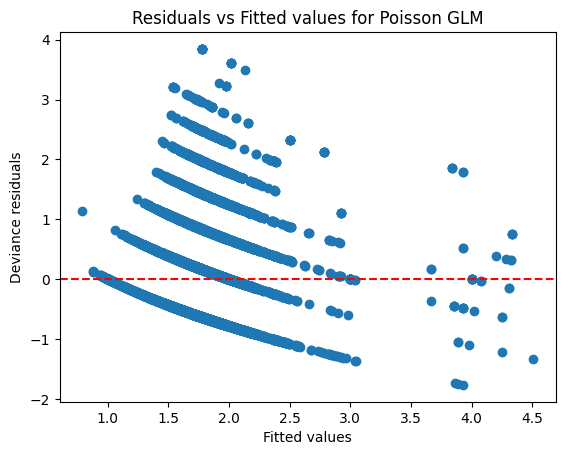

In [ ]:
residuals = poisson_results.resid_deviance

# Plot residuals vs fitted values
plt.scatter(poisson_results.fittedvalues, residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Deviance residuals')
plt.title('Residuals vs Fitted values for Poisson GLM')
plt.show()

# Xgboost With Target Encoding

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

# Define categorical and numerical columns
categorical_cols = [' COLORS', 'BODY TYPE', 'VEHICLE MAKE', 'VEHICLE MODELS']
numerical_cols = ['CAR_AGE', 'CUBIC_CAPACITY', 'CARRY_CAPACITY']
target = 'Claim_Frequency'

# One-hot encode the categorical variables
df_encoded = pd.get_dummies(df[categorical_cols], drop_first=True)

# Combine numerical and encoded categorical features
X = pd.concat([df[numerical_cols], df_encoded], axis=1)

# Convert boolean columns to integers (if necessary)
X = X.astype(int)

# Debug step: Check data types again to ensure all columns are numeric
print(X.dtypes)

# Target variable
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters for the XGBoost model
params = {
    'objective': 'count:poisson',  # Use Poisson regression
    'eval_metric': 'mae',  # Mean Absolute Error
    'eta': 0.1,  # Learning rate
    'max_depth': 6,  # Maximum depth of the trees
    'alpha': 1,  # L1 regularization term
    'lambda': 1  # L2 regularization term
}

# Train the XGBoost model
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Predict on test set
y_pred = xgb_model.predict(dtest)

# Evaluate predictions
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Predicted values:", y_pred[:5])


CAR_AGE                      int64
CUBIC_CAPACITY               int64
CARRY_CAPACITY               int64
 COLORS_BLACK                int64
 COLORS_BLUE                 int64
                             ...  
VEHICLE MODELS_VOLVO V60     int64
VEHICLE MODELS_VOLVO V70     int64
VEHICLE MODELS_VOLVO XC60    int64
VEHICLE MODELS_VOLVO XC90    int64
VEHICLE MODELS_WHEELER       int64
Length: 642, dtype: object
Mean Absolute Error: 0.7890880494242452
Mean Squared Error: 1.0413901114116153
Predicted values: [1.770044  1.7725397 1.7101616 1.9132441 1.7279088]


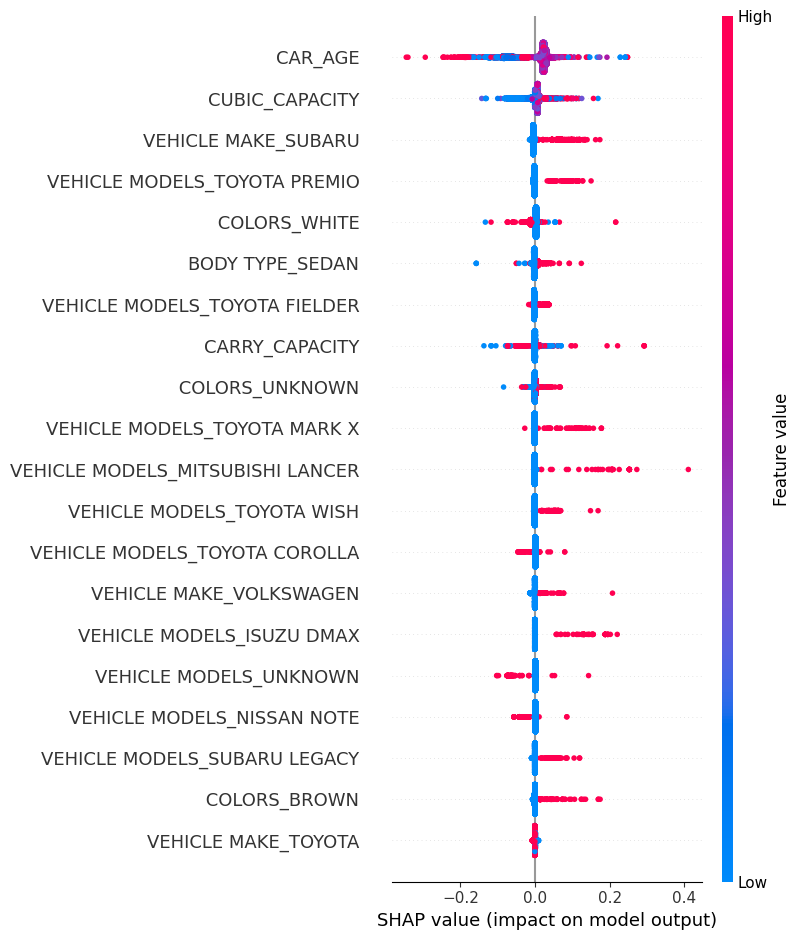

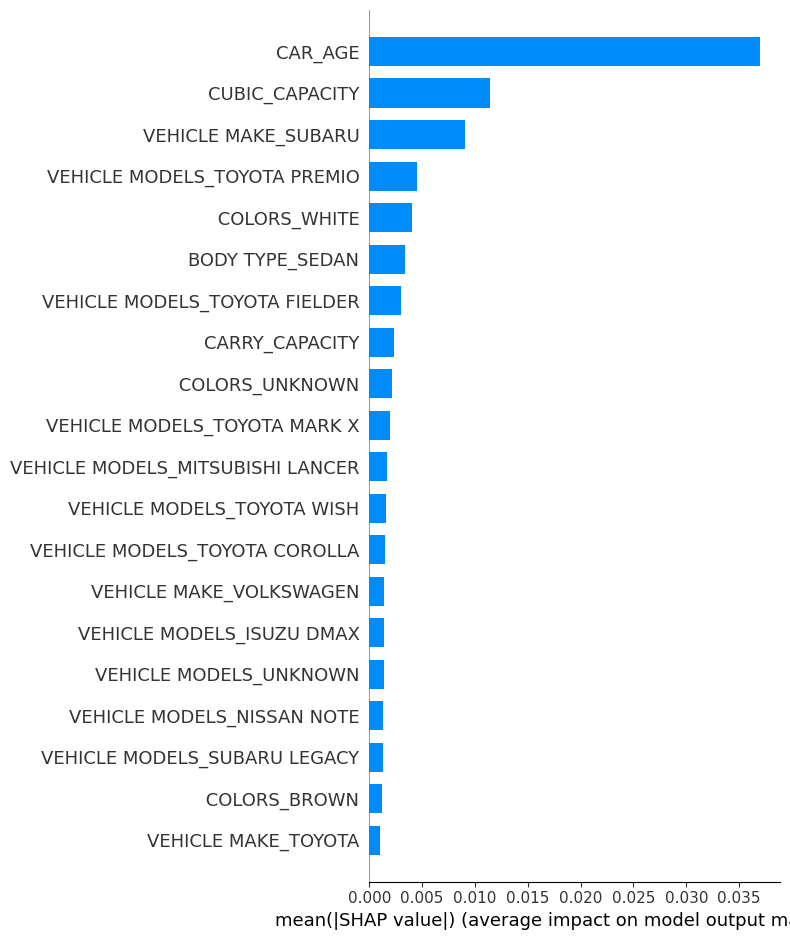

In [ ]:
import shap
explainer = shap.Explainer(xgb_model)

# Calculate SHAP values
shap_values = explainer(X_test)

# Create a summary plot for feature importance
shap.summary_plot(shap_values, X_test)

# If you want a bar plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
instance_index = 0  # Change this to analyze different instances
shap.force_plot(explainer.expected_value, shap_values[instance_index], X_test.iloc[instance_index])

ValueError: visualize() can only display Explanation objects (or arrays of them)!

In [ ]:
# prompt: print(X.dtypes)

print(X.dtypes)

# Poisson Target Encoding Polynomial Features

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.linear_model import PoissonRegressor



# Define the feature and target variables
categorical_cols = [' COLORS', 'BODY TYPE', 'VEHICLE MAKE', 'VEHICLE MODELS']
numerical_cols = ['CAR_AGE', 'CUBIC_CAPACITY', 'CARRY_CAPACITY']
target = 'Claim_Frequency'

# Target encode categorical variables
encoder = TargetEncoder(cols=categorical_cols)
df_encoded = encoder.fit_transform(df[categorical_cols], df[target])

# Combine numerical and encoded categorical features
X = pd.concat([df[numerical_cols], df_encoded], axis=1)

# Impute missing values (if any) with SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Generate polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_imputed)

# Get feature names for the polynomial features
combined_feature_names = numerical_cols + list(df_encoded.columns)
poly_feature_names = poly.get_feature_names_out(combined_feature_names)
X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names)

# Add a constant (intercept term) for the GLM
X_poly_df = sm.add_constant(X_poly_df)

# Target variable
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly_df, y, test_size=0.2, random_state=42)

# Fit a GLM model with Poisson distribution
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

# Print model summary
print(poisson_results.summary())

# Predict on the test set
y_pred = poisson_results.predict(X_test)

# Evaluate predictions (you can choose different evaluation metrics here)
print("Predicted values (first 5):", y_pred[:5])

                 Generalized Linear Model Regression Results                  
Dep. Variable:        Claim_Frequency   No. Observations:                33949
Model:                            GLM   Df Residuals:                    33913
Model Family:                 Poisson   Df Model:                           35
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -48759.
Date:                Tue, 22 Oct 2024   Deviance:                       16771.
Time:                        13:03:21   Pearson chi2:                 1.96e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.02110
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

# Model evaluation

In [ ]:
import statsmodels.api as sm

# Assuming your model is fitted and named 'model'
deviance_value = poisson_results.deviance
aic_value = poisson_results.aic

print("Deviance:", deviance_value)
print("AIC:", aic_value)

Deviance: 16770.718320073127
AIC: 97589.06418809664


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import PoissonRegressor  # GLM Poisson regressor
import statsmodels.api as sm

# Categorical and numerical columns
categorical_cols = [' COLORS', 'BODY TYPE', 'VEHICLE MAKE', 'VEHICLE MODELS']
numerical_cols = ['CAR_AGE', 'CUBIC_CAPACITY', 'CARRY_CAPACITY']
target = 'Claim_Frequency'

# Target encode categorical variables
encoder = TargetEncoder(cols=categorical_cols)
df_encoded = encoder.fit_transform(df[categorical_cols], df[target])

# Combine numerical and encoded categorical features
X = pd.concat([df[numerical_cols], df_encoded], axis=1)

# Impute missing values (if any) with SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Generate polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_imputed)

# Get feature names for the polynomial features
combined_feature_names = numerical_cols + list(df_encoded.columns)
poly_feature_names = poly.get_feature_names_out(combined_feature_names)
X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names)

# Add a constant (intercept term) for the GLM
X_poly_df = sm.add_constant(X_poly_df)

# Target variable
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly_df, y, test_size=0.2, random_state=42)

# Initialize a Poisson Regressor for RFE
poisson_reg = PoissonRegressor(alpha=0.0, fit_intercept=False, max_iter=1000)

# Apply RFE (Recursive Feature Elimination) for feature selection
selector = RFE(estimator=poisson_reg, n_features_to_select=50, step=1)  # Select top 25 features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Print selected features
selected_features = X_train.columns[selector.support_]
print("Selected Features:", selected_features)

# Create a mapping of selected features to their coefficients
feature_mapping = {f'x{i+1}': feature for i, feature in enumerate(selected_features)}

# Fit a GLM model with Poisson distribution using selected features
poisson_model = sm.GLM(y_train, X_train_selected, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

# Print model summary
print(poisson_results.summary())

# Print the mapping of selected features to coefficients
print("Feature to Coefficient Mapping:")
for key, value in feature_mapping.items():
    print(f"{key}: {value}")

# Predict on the test set using selected features
y_pred = poisson_results.predict(X_test_selected)

# Evaluate predictions
print("Predicted values (first 5):", y_pred[:5])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=50 > n_features=36. There will be no feature selection and all features will be kept.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_linear_loss.py:295: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights


Selected Features: Index(['const', 'CAR_AGE', 'CUBIC_CAPACITY', 'CARRY_CAPACITY', ' COLORS',
       'BODY TYPE', 'VEHICLE MAKE', 'VEHICLE MODELS', 'CAR_AGE^2',
       'CAR_AGE CUBIC_CAPACITY', 'CAR_AGE CARRY_CAPACITY', 'CAR_AGE  COLORS',
       'CAR_AGE BODY TYPE', 'CAR_AGE VEHICLE MAKE', 'CAR_AGE VEHICLE MODELS',
       'CUBIC_CAPACITY^2', 'CUBIC_CAPACITY CARRY_CAPACITY',
       'CUBIC_CAPACITY  COLORS', 'CUBIC_CAPACITY BODY TYPE',
       'CUBIC_CAPACITY VEHICLE MAKE', 'CUBIC_CAPACITY VEHICLE MODELS',
       'CARRY_CAPACITY^2', 'CARRY_CAPACITY  COLORS',
       'CARRY_CAPACITY BODY TYPE', 'CARRY_CAPACITY VEHICLE MAKE',
       'CARRY_CAPACITY VEHICLE MODELS', ' COLORS^2', ' COLORS BODY TYPE',
       ' COLORS VEHICLE MAKE', ' COLORS VEHICLE MODELS', 'BODY TYPE^2',
       'BODY TYPE VEHICLE MAKE', 'BODY TYPE VEHICLE MODELS', 'VEHICLE MAKE^2',
       'VEHICLE MAKE VEHICLE MODELS', 'VEHICLE MODELS^2'],
      dtype='object')
                 Generalized Linear Model Regression Results       

In [ ]:
print(df.isna().sum())

CMB_CLAIM_NO       0
POLICY_NO          0
EF                 0
ET                 0
LOSS_DATE          0
REPORT DATE        0
Vehicle_ID         0
YOM                0
AGE_CATEGORY       0
CAR_AGE            0
 COLORS            0
CUBIC_CAPACITY     0
CARRY_CAPACITY     0
BODY TYPE          0
REG_Name           0
VEHICLE MAKE       0
VEHICLE MODELS     0
GROSS_PAID         0
Claim_Frequency    0
dtype: int64


In [ ]:
feature_mapping = list(poly_feature_names)
print(feature_mapping)

['CAR_AGE', 'CUBIC_CAPACITY', 'CARRY_CAPACITY', ' COLORS', 'BODY TYPE', 'VEHICLE MAKE', 'VEHICLE MODELS', 'CAR_AGE^2', 'CAR_AGE CUBIC_CAPACITY', 'CAR_AGE CARRY_CAPACITY', 'CAR_AGE  COLORS', 'CAR_AGE BODY TYPE', 'CAR_AGE VEHICLE MAKE', 'CAR_AGE VEHICLE MODELS', 'CUBIC_CAPACITY^2', 'CUBIC_CAPACITY CARRY_CAPACITY', 'CUBIC_CAPACITY  COLORS', 'CUBIC_CAPACITY BODY TYPE', 'CUBIC_CAPACITY VEHICLE MAKE', 'CUBIC_CAPACITY VEHICLE MODELS', 'CARRY_CAPACITY^2', 'CARRY_CAPACITY  COLORS', 'CARRY_CAPACITY BODY TYPE', 'CARRY_CAPACITY VEHICLE MAKE', 'CARRY_CAPACITY VEHICLE MODELS', ' COLORS^2', ' COLORS BODY TYPE', ' COLORS VEHICLE MAKE', ' COLORS VEHICLE MODELS', 'BODY TYPE^2', 'BODY TYPE VEHICLE MAKE', 'BODY TYPE VEHICLE MODELS', 'VEHICLE MAKE^2', 'VEHICLE MAKE VEHICLE MODELS', 'VEHICLE MODELS^2']


In [ ]:
categorical_cols = [' COLORS', 'BODY TYPE', 'VEHICLE MAKE', 'VEHICLE MODELS']
numerical_cols = ['CAR_AGE', 'CUBIC_CAPACITY', 'CARRY_CAPACITY']
target = 'Claim_Frequency'

# Target encode categorical variables
encoder = TargetEncoder(cols=categorical_cols)
df_encoded = encoder.fit_transform(df[categorical_cols], df[target])

# Combine numerical and encoded categorical features
X = pd.concat([df[numerical_cols], df_encoded], axis=1)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Generate polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_imputed)

# Get feature names for the polynomial features
combined_feature_names = numerical_cols + list(df_encoded.columns)
poly_feature_names = poly.get_feature_names_out(combined_feature_names)
X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names)

# Add a constant for the GLM
X_poly_df = sm.add_constant(X_poly_df)

# Target variable
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly_df, y, test_size=0.2, random_state=42)

# Initialize a Poisson Regressor for RFE
poisson_reg = PoissonRegressor(alpha=0.0, fit_intercept=False, max_iter=1000)

# Apply RFE for feature selection
selector = RFE(estimator=poisson_reg, n_features_to_select=50, step=1)  # Select top 25 features
X_train_selected = selector.fit_transform(X_train, y_train)

# Define the test set selected features after RFE
X_test_selected = selector.transform(X_test)

# Retain original variables
original_vars = X_train[numerical_cols].reset_index(drop=True)

# Convert selected features back to DataFrame
X_train_selected_df = pd.DataFrame(X_train_selected, columns=X_train.columns[selector.support_]).reset_index(drop=True)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=X_test.columns[selector.support_]).reset_index(drop=True)

# Combine original numerical variables with selected polynomial features
X_train_final = pd.concat([original_vars, X_train_selected_df], axis=1)
X_test_final = pd.concat([X_test[numerical_cols].reset_index(drop=True), X_test_selected_df.reset_index(drop=True)], axis=1)

# Ensure y_train has the same index as X_train_final
y_train_final = y_train.reset_index(drop=True)

# Fit a GLM model with Poisson distribution using final selected features
poisson_model = sm.GLM(y_train_final, X_train_final, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

# Print model summary
print(poisson_results.summary())

# Predict on the test set using final selected features
y_pred = poisson_results.predict(X_test_final)

# Evaluate predictions
print("Predicted values (first 5):", y_pred[:5])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=50 > n_features=36. There will be no feature selection and all features will be kept.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_linear_loss.py:295: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights


                 Generalized Linear Model Regression Results                  
Dep. Variable:        Claim_Frequency   No. Observations:                33949
Model:                            GLM   Df Residuals:                    33913
Model Family:                 Poisson   Df Model:                           35
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -48759.
Date:                Mon, 14 Oct 2024   Deviance:                       16771.
Time:                        05:15:33   Pearson chi2:                 1.96e+04
No. Iterations:                     6   Pseudo R-squ. (CS):            0.02110
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
CAR_AGE       

In [ ]:
print(df_encoded.head())


     COLORS  BODY TYPE  VEHICLE MAKE  VEHICLE MODELS
0  1.750453   1.731666      1.742292        1.614402
1  1.689609   1.731666      1.742292        1.589499
2  1.733873   1.731666      1.943775        1.831880
3  1.733873   1.799585      1.580508        1.781384
4  1.750453   1.731666      1.682950        1.767480


In [ ]:
color_encoding = df.groupby(' COLORS')['Claim_Frequency'].mean().reset_index()

# Print the encoding
print(color_encoding)

     COLORS  Claim_Frequency
0      BLUE         1.800000
1     BLACK         1.750453
2      BLUE         1.738817
3     BROWN         1.780664
4      GOLD         1.657143
5     GREEN         1.617886
6      GREY         1.807841
7    MAROON         1.592593
8    ORANGE         2.043860
9      PINK         1.716981
10   PURPLE         1.677165
11      RED         1.749158
12   SILVER         1.733873
13  UNKNOWN         1.779468
14    WHITE         1.689609
15   YELLOW         1.461538


In [ ]:
beta_0 = -5.8636
beta_car_age = 0.0865
beta_carry_capacity = -0.1255

# Define the coefficients for each color
beta_color = np.array([
    1.800000,  # BLUE
    1.750453,  # BLACK
    1.780664,  # BROWN
    1.657143,  # GOLD
    1.617886,  # GREEN
    1.807841,  # GREY
    1.592593,  # MAROON
    2.043860,  # ORANGE
    1.716981,  # PINK
    1.677165,  # PURPLE
    1.749158,  # RED
    1.733873,  # SILVER
    1.779468,  # UNKNOWN
    1.689609,  # WHITE
    1.461538   # YELLOW
])

# Define the interaction coefficients for Car Age x Color
beta_car_age_color = np.array([
    -0.0566,  # BLUE
    # Fill in the rest...
])

# Define the interaction coefficients for Carry Capacity x Color
beta_carry_capacity_color = np.array([
    0.3250,  # BLUE
    # Fill in the rest...
])

# Define your values
car_ages = np.array([10, 13, 7, 17, 15, 19])  # Example car ages
carry_capacities = np.array([5, 8, 7, 4, 2])  # Example carry capacities
colors_encoded = np.arange(len(beta_color))  # Assuming colors are encoded as integers

# Create a grid of all combinations of car_age, carry_capacity, and colors
car_age_grid, carry_capacity_grid, color_grid = np.meshgrid(car_ages, carry_capacities, colors_encoded, indexing='ij')

# Calculate the linear predictor (eta) for each combination
eta_grid = (beta_0 +
            beta_car_age * car_age_grid +
            beta_carry_capacity * carry_capacity_grid +
            beta_color[color_grid] +  # Categorical coefficient for color
            beta_car_age_color[color_grid] * car_age_grid +  # Interaction: Car Age x Color
            beta_carry_capacity_color[color_grid] * carry_capacity_grid)  # Interaction: Carry Capacity x Color

# Get the predicted claim frequency by applying the exponential function
predicted_frequencies = np.exp(eta_grid)

# Flatten arrays and organize results into a DataFrame for better visualization
results_df = pd.DataFrame({
    'Car_Age': car_age_grid.flatten(),
    'Carry_Capacity': carry_capacity_grid.flatten(),
    'Color': color_grid.flatten(),
    'Predicted_Claim_Frequency': predicted_frequencies.flatten()
})

# View the first few rows
print(results_df.head())

# Optionally save to Excel for further analysis
results_df.to_excel('predicted_claim_frequencies.xlsx', index=False)
files.download('predicted_claim_frequencies.xlsx')

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
from google.colab import files

In [ ]:
import numpy as np
import pandas as pd

# Function to predict claim frequency with significant interactions
def predict_claim_frequency_extended(car_ages, carry_capacities, colors, cubic_capacities):
    # Ensure inputs are NumPy arrays for vectorized operations
    car_ages = np.array(car_ages)
    carry_capacities = np.array(carry_capacities)
    colors = np.array(colors)
    cubic_capacities = np.array(cubic_capacities)

    # Coefficients from your model (extracted from the GLM results)
    coef_const = -5.8636
    coef_car_age = 0.0865
    coef_carry_capacity = -0.1255
    coef_colors = -3.4708
    coef_cubic_capacity = 0.0003

    # Interaction terms
    coef_car_age_carry_capacity = -0.0041
    coef_car_age_colors = -0.0566
    coef_cubic_capacity_carry_capacity = 2.091e-05
    coef_carry_capacity_colors = 0.3250

    # Compute the linear predictor (log-claim frequency) for each combination of values
    eta = (coef_const +
           coef_car_age * car_ages +
           coef_carry_capacity * carry_capacities +
           coef_colors * colors +
           coef_cubic_capacity * cubic_capacities +
           coef_car_age_carry_capacity * car_ages * carry_capacities +
           coef_car_age_colors * car_ages * colors +
           coef_cubic_capacity_carry_capacity * cubic_capacities * carry_capacities +
           coef_carry_capacity_colors * carry_capacities * colors)

    # Calculate the predicted claim frequency (exponential of the linear predictor)
    predicted_frequencies = np.exp(eta)

    return predicted_frequencies

# Example data (adjusted for matching sizes)
car_ages = [5, 10, 7, 12]  # Example car ages
carry_capacities = [5, 8, 10, 2]  # Example carry capacities
colors = [1.800000,1.750453,1.738817,1.780664]  # Example encoded color values (from target encoding)
cubic_capacities = [1500, 2000, 1490, 4000]  # Example cubic capacities

# Handling larger number of cubic capacities (e.g., 547 unique values)
# Assuming you have an array of 547 unique cubic capacities, you'd either loop or vectorize over these.
# For now, we'll just demonstrate a smaller set.
predicted_freqs = predict_claim_frequency_extended(car_ages, carry_capacities, colors, cubic_capacities)

# Create a DataFrame
predicted_freqs_df = pd.DataFrame({
    'Car Age': car_ages,
    'Carry Capacity': carry_capacities,
    'Colors': colors,
    'Cubic Capacity': cubic_capacities,
    'Predicted Claim Frequency': predicted_freqs
})

# Save DataFrame to Excel file
file_path = "predicted_claim_frequencies.xlsx"
predicted_freqs_df.to_excel(file_path, index=False)

# Download the file (if in Jupyter or Google Colab, not needed for local scripts)
files.download(file_path)

# Print the results to console
for car_age, carry_capacity, color, cubic_capacity, predicted_freq in zip(car_ages, carry_capacities, colors, cubic_capacities, predicted_freqs):
    print(f"Car Age: {car_age}, Carry Capacity: {carry_capacity}, Colors: {color}, Cubic Capacity: {cubic_capacity}, Predicted Claim Frequency: {predicted_freq}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Car Age: 5, Carry Capacity: 5, Colors: 1.8, Cubic Capacity: 1500, Predicted Claim Frequency: 8.38807005628606e-05
Car Age: 10, Carry Capacity: 8, Colors: 1.750453, Cubic Capacity: 2000, Predicted Claim Frequency: 0.0003666543899357007
Car Age: 7, Carry Capacity: 10, Colors: 1.738817, Cubic Capacity: 1490, Predicted Claim Frequency: 0.0008133157975230853
Car Age: 12, Carry Capacity: 2, Colors: 1.780664, Cubic Capacity: 4000, Predicted Claim Frequency: 4.361785382626163e-05


# Negative binomial with vehicle models target Encoded


In [ ]:
import pandas as pd
import statsmodels.api as sm
import category_encoders as ce
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
df_encoded = pd.get_dummies(df, columns=['VEHICLE MAKE', ' COLORS', 'BODY TYPE'], drop_first=True)
# Prepare your target variable
y = df['Claim_Frequency']

# Create a target encoder object
target_encoder = ce.TargetEncoder(cols=['VEHICLE MODELS'])

# Fit the encoder and transform the 'VEHICLE MODELS' column
df_encoded['VEHICLE_MODELS_ENCODED'] = target_encoder.fit_transform(df['VEHICLE MODELS'], y)
X = df_encoded[['CUBIC_CAPACITY', 'CAR_AGE', 'CARRY_CAPACITY', 'VEHICLE_MODELS_ENCODED'] +
               [col for col in df_encoded.columns if col.startswith(('VEHICLE MAKE', ' COLORS', 'BODY TYPE'))]]

poly = PolynomialFeatures(include_bias=False)
X_poly = poly.fit_transform(X)

# Convert to DataFrame for easier handling
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X.columns))
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly_df)

# Add a constant (intercept)
X_with_const = sm.add_constant(X_scaled)
model_nb = sm.NegativeBinomial(y, X_with_const).fit()

# Print the summary
model_nb_summary = model_nb.summary(xname=['const'] + X_poly_df.columns.tolist())
print(model_nb_summary)

KeyboardInterrupt: 

In [ ]:
print(df_encoded.columns)

Index([' COLORS', 'BODY TYPE', 'VEHICLE MAKE', 'VEHICLE MODELS'], dtype='object')


# Predicting Claim Frequency For The Significant Variables

In [ ]:
const = -5.8636
beta_car_age = 0.0865
beta_carry_capacity = -0.1255
beta_interaction = -0.0041  # Coefficient for CAR_AGE CARRY_CAPACITY

# Define carry capacity and car age arrays
carry_capacity = np.array([5, 8, 7, 4, 2, 3, 9, 6, 10])
car_age = np.array([10, 13, 7, 17, 15, 19, 11, 12, 14, 20,
                    16, 18, 24, 23, 21, 38, 9, 25, 22, 6,
                    26, 8, 5, 2, 30, 0, 3, 1, 4, 27,
                    29, 34, 28, 33, 32, 37, 31, 36, 40, 35])

# Create a DataFrame to store the results
results = []

for capacity in carry_capacity:
    for age in car_age:
        # Calculate the expected log frequency
        log_expected_frequency = (const +
                                  beta_car_age * age +
                                  beta_carry_capacity * capacity +
                                  beta_interaction * age * capacity)
        # Exponentiate to get the expected frequency
        expected_frequency = np.exp(log_expected_frequency)
        results.append((age, capacity, expected_frequency))

# Create a DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['Car Age', 'Carry Capacity', 'Expected Frequency'])

# Display the results
print(results_df)
file_path = "predicted_claim_frequencies for AGE CARRY CAPACITY COMBINATION.xlsx"
results_df.to_excel(file_path, index=False)


     Car Age  Carry Capacity  Expected Frequency
0         10               5            0.002935
1         13               5            0.003577
2          7               5            0.002408
3         17               5            0.004658
4         15               5            0.004082
..       ...             ...                 ...
355       37              10            0.004361
356       31              10            0.003319
357       36              10            0.004167
358       40              10            0.004999
359       35              10            0.003981

[360 rows x 3 columns]


Text(0, 0.5, 'Carry Capacity')

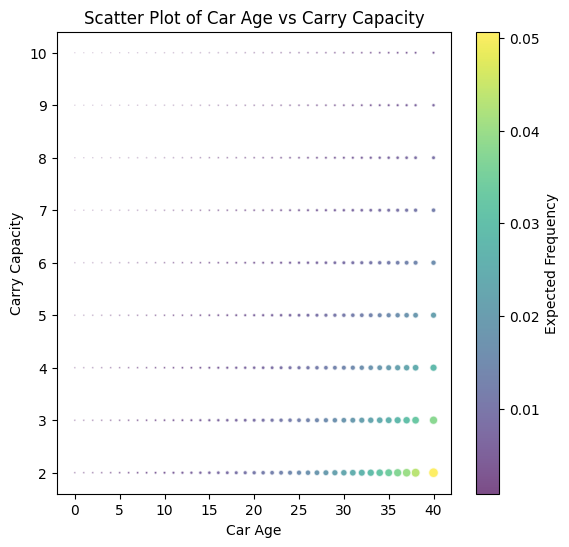

In [ ]:
plt.figure(figsize=(14, 6))

# Scatter Plot
plt.subplot(1, 2, 1)
scatter = plt.scatter(results_df['Car Age'], results_df['Carry Capacity'],
                      s=results_df['Expected Frequency'] * 1000,  # Scale bubble size
                      c=results_df['Expected Frequency'],
                      cmap='viridis', alpha=0.7, edgecolors='w')
plt.colorbar(scatter, label='Expected Frequency')
plt.title('Scatter Plot of Car Age vs Carry Capacity')
plt.xlabel('Car Age')
plt.ylabel('Carry Capacity')

# # Heatmap
# plt.subplot(1, 2, 2)
# # Create bins for Car Age and Carry Capacity
# results_df['Car Age Binned'] = pd.cut(results_df['Car Age'], bins=5)
# results_df['Carry Capacity Binned'] = pd.cut(results_df['Carry Capacity'], bins=5)

# # Pivot the DataFrame for the heatmap
# heatmap_data = results_df.pivot_table(values='Expected Frequency',
#                                        index='Car Age Binned',
#                                        columns='Carry Capacity Binned',
#                                        observed=False)  # Specify observed=False

# # Create the heatmap
# sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='.2f')
# plt.title('Heatmap of Expected Frequency by Car Age and Carry Capacity')
# plt.xlabel('Carry Capacity Binned')
# plt.ylabel('Car Age Binned')

# # Show the plots
# plt.tight_layout()
# plt.show()

In [ ]:
files.download("predicted_claim_frequencies for AGE CARRY CAPACITY COMBINATION.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
const = -5.8636
beta_car_age = 0.0865
beta_colors = -3.4708  # Coefficient for COLORS
beta_interaction = -0.0566  # Coefficient for CAR_AGE COLORS

# Define car age array
car_age = np.array([10, 13, 7, 17, 15, 19, 11, 12, 14, 20,
                    16, 18, 24, 23, 21, 38, 9, 25, 22, 6,
                    26, 8, 5, 2, 30, 0, 3, 1, 4, 27,
                    29, 34, 28, 33, 32, 37, 31, 36, 40, 35])

# Create a mapping of colors to their average claim frequency
color_mapping = {
    'BLUE': 1.800000,
    'BLACK': 1.750453,
    'BROWN': 1.780664,
    'GOLD': 1.657143,
    'GREEN': 1.617886,
    'GREY': 1.807841,
    'MAROON': 1.592593,
    'ORANGE': 2.043860,
    'PINK': 1.716981,
    'PURPLE': 1.677165,
    'RED': 1.749158,
    'SILVER': 1.733873,
    'UNKNOWN': 1.779468,
    'WHITE': 1.689609,
    'YELLOW': 1.461538
}

# Convert color mapping to a DataFrame for iteration
colors = list(color_mapping.keys())
color_values = list(color_mapping.values())

# Create a DataFrame to store the results
results = []

for color, value in zip(colors, color_values):
    for age in car_age:
        # Calculate the expected log frequency
        log_expected_frequency = (const +
                                  beta_car_age * age +
                                  beta_colors * value +
                                  beta_interaction * age * value)
        # Exponentiate to get the expected frequency
        expected_frequency = np.exp(log_expected_frequency)
        results.append((age, color, expected_frequency))

# Create a DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['Car Age', 'Color', 'Expected Frequency'])

# Display the results
print(results_df)
file_path = "predicted_claim_frequencies for AGE COLORS COMBINATION.xlsx"
results_df.to_excel("predicted_claim_frequencies for AGE COLORS COMBINATION.xlsx", index=False)

     Car Age   Color  Expected Frequency
0         10    BLUE            0.000005
1         13    BLUE            0.000005
2          7    BLUE            0.000005
3         17    BLUE            0.000004
4         15    BLUE            0.000004
..       ...     ...                 ...
595       37  YELLOW            0.000020
596       31  YELLOW            0.000020
597       36  YELLOW            0.000020
598       40  YELLOW            0.000021
599       35  YELLOW            0.000020

[600 rows x 3 columns]


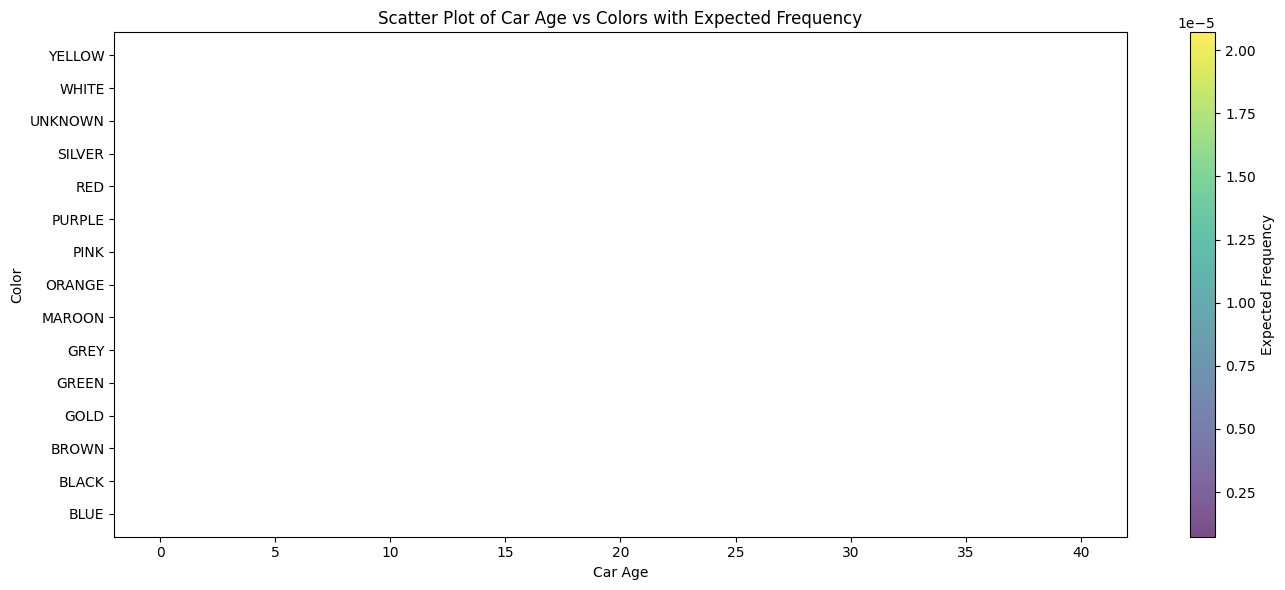

In [ ]:
color_mapping_plot = {color: idx for idx, color in enumerate(colors)}

# Create a column in the DataFrame that converts color names to integers
results_df['Color_Mapped'] = results_df['Color'].map(color_mapping_plot)

# Set up figure size
plt.figure(figsize=(14, 6))

# Scatter Plot of Car Age vs Colors
scatter = plt.scatter(results_df['Car Age'], results_df['Color_Mapped'],
                      s=results_df['Expected Frequency'] * 900,  # Adjusted scaling factor
                      c=results_df['Expected Frequency'],
                      cmap='viridis', alpha=0.7, edgecolors='w')

# Add color bar
plt.colorbar(scatter, label='Expected Frequency')

# Set x and y labels
plt.xlabel('Car Age')
plt.ylabel('Color')

# Customize y-ticks to show color names instead of integers
plt.yticks(ticks=list(color_mapping_plot.values()), labels=list(color_mapping_plot.keys()))

# Title
plt.title('Scatter Plot of Car Age vs Colors with Expected Frequency')

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
files.download("predicted_claim_frequencies for AGE COLORS COMBINATION.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

# Assuming your dataset is loaded into a DataFrame called `df`
# Extract unique values from your columns
unique_cubic_capacity = df['CUBIC_CAPACITY'].unique()  # Extract unique cubic capacities
unique_carry_capacity = df['CARRY_CAPACITY'].unique()  # Extract unique carry capacities

# Coefficients from your GLM model
const = -5.8636
beta_cubic_capacity = 0.0003  # Coefficient for CUBIC_CAPACITY
beta_carry_capacity = -0.1255   # Coefficient for CARRY_CAPACITY
beta_interaction = 2.091e-05  # Coefficient for CUBIC_CAPACITY CARRY_CAPACITY

# Create a DataFrame to store the results
results = []

# Loop through each combination of cubic capacity and carry capacity
for cubic in unique_cubic_capacity:
    for carry in unique_carry_capacity:
        # Calculate the expected log frequency
        log_expected_frequency = (const +
                                  beta_cubic_capacity * cubic +
                                  beta_carry_capacity * carry +
                                  beta_interaction * cubic * carry)
        # Exponentiate to get the expected frequency
        expected_frequency = np.exp(log_expected_frequency)
        # Append the result to the list
        results.append((cubic, carry, expected_frequency))

# Convert the results to a DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['Cubic Capacity', 'Carry Capacity', 'Expected Frequency'])

# Sort the DataFrame to find the combination with the highest expected frequency
results_df_sorted = results_df.sort_values(by='Expected Frequency', ascending=False)
file_path = "predicted_claim_frequencies for CC Carry Capacity COMBINATION.xlsx"
results_df.to_excel("predicted_claim_frequencies for CC Carry Capacity COMBINATION.xlsx", index=False)

# Display the top 10 combinations with the highest expected claim frequency
print(results_df_sorted.head(10))
files.download("predicted_claim_frequencies for CC Carry Capacity COMBINATION.xlsx")

      Cubic Capacity  Carry Capacity  Expected Frequency
3365          5700.0             1.0            0.015609
3360          5700.0             2.0            0.015511
4146          5663.0             1.0            0.015425
3361          5700.0             3.0            0.015413
3937          5660.0             1.0            0.015410
3359          5700.0             4.0            0.015316
4141          5663.0             2.0            0.015316
3932          5660.0             2.0            0.015300
3355          5700.0             5.0            0.015220
4142          5663.0             3.0            0.015208


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

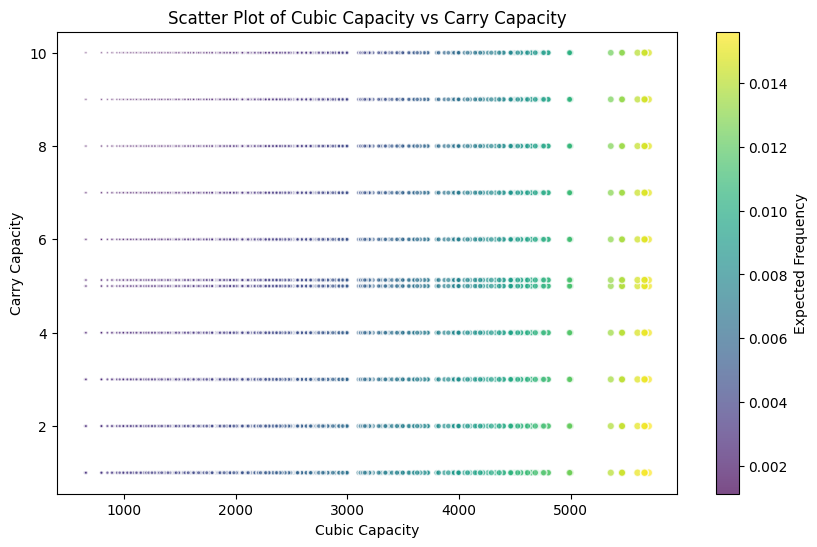

In [ ]:
plt.figure(figsize=(10, 6))

# Scatter plot for Cubic Capacity vs Carry Capacity
scatter = plt.scatter(results_df['Cubic Capacity'], results_df['Carry Capacity'],
                      s=results_df['Expected Frequency'] * 2000,  # Scale bubble size based on expected frequency
                      c=results_df['Expected Frequency'],
                      cmap='viridis', alpha=0.7, edgecolors='w')

# Add a color bar to show the scale of expected frequency
plt.colorbar(scatter, label='Expected Frequency')

# Title and labels
plt.title('Scatter Plot of Cubic Capacity vs Carry Capacity')
plt.xlabel('Cubic Capacity')
plt.ylabel('Carry Capacity')

# Show plot
plt.show()